In [ ]:
# Install for GPU acceleration
!pip install setuptools pip wheel --upgrade
!pip install nvidia-pyindex
!pip install nvidia-cuda-runtime-cu12

# Install TensorFlow
!pip install tflite-model-maker
!pip install librosa --upgrade
!pip install tensorflow-datasets==4.8.3

In [1]:
import os
import glob
import random

import soundfile as sf
from IPython.display import Audio
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tflite_model_maker as mm
from tflite_model_maker import audio_classifier

from IPython.display import Audio, Image
from scipy.io import wavfile

print(f"TensorFlow Version: {tf.__version__}")
print(f"Model Maker Version: {mm.__version__}")

c:\Users\kmwh0\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\kmwh0\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.10.0 and strictly below 2.13.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.9.3 and is not supported. 
Some things might work, some things might not.
If you were to encounter

TensorFlow Version: 2.9.3
Model Maker Version: 0.3.4


In [4]:
dataset_dir = './dataset'
test_dir = './dataset-test'

In [5]:
def get_random_audio_file(samples_dir):
  files = os.path.abspath(os.path.join(samples_dir, '*/*.wav'))
  files_list = glob.glob(files)
  random_audio_path = random.choice(files_list)
  return random_audio_path

def show_sample(audio_path):
  audio_data, sample_rate = sf.read(audio_path) 
  class_name = os.path.basename(os.path.dirname(audio_path))
  print(f'Class: {class_name}')
  print(f'File: {audio_path}')
  print(f'Sample rate: {sample_rate}')
  print(f'Sample length: {len(audio_data)}')

  plt.title(class_name)
  plt.plot(audio_data)
  display(Audio(audio_data, rate=sample_rate))

Class: 차량사이렌
File: d:\Dev2023\audio-model-maker-test\dataset-test\차량사이렌\1.자동차_70640_1_mono_16bit.wav
Sample rate: 44100
Sample length: 454494


findfont: Font family ['NanumSquare'] not found. Falling back to DejaVu Sans.
c:\Users\kmwh0\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 52264 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\kmwh0\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 47049 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\kmwh0\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 49324 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\kmwh0\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 51060 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\kmwh0\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\backends\backend_agg.py

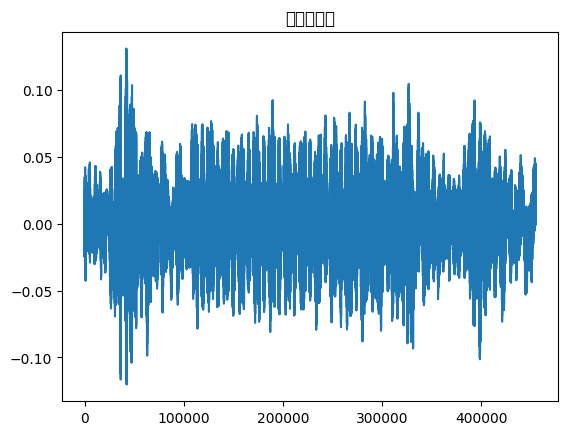

In [6]:
random_audio = get_random_audio_file(test_dir)
show_sample(random_audio)

In [14]:
spec = audio_classifier.YamNetSpec(
    keep_yamnet_and_custom_heads=False,
    frame_step=1 * audio_classifier.YamNetSpec.EXPECTED_WAVEFORM_LENGTH,
    frame_length=3 * audio_classifier.YamNetSpec.EXPECTED_WAVEFORM_LENGTH)

tf.config.list_physical_devices('GPU')
tf.debugging.set_log_device_placement(False)

train_data_ratio = 0.8
train_data = audio_classifier.DataLoader.from_folder(spec, dataset_dir, cache=True)
train_data, validation_data = train_data.split(train_data_ratio)
test_data = audio_classifier.DataLoader.from_folder(spec, test_dir, cache=True)

batch_size = 25
epochs = 25
model = audio_classifier.create(train_data, spec, validation_data, batch_size, epochs)

INFO:tensorflow:Checkpoints are stored in C:\Users\kmwh0\AppData\Local\Temp\tmpxrilk1hm


INFO:tensorflow:Checkpoints are stored in C:\Users\kmwh0\AppData\Local\Temp\tmpxrilk1hm


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 classification_head (Dense)  (None, 24)               24600     
                                                                 
Total params: 24,600
Trainable params: 24,600
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
577/577 [==============================] - 128s 219ms/step - loss: 1.7326 - acc: 0.5173 - val_loss: 1.0971 - val_acc: 0.7027
Epoch 2/25
577/577 [==============================] - 2s 4ms/step - loss: 1.0339 - acc: 0.7358 - val_loss: 0.8877 - val_acc: 0.7522
Epoch 3/25
577/577 [==============================] - 2s 4ms/step - loss: 0.8502 - acc: 0.7799 - val_loss: 0.8024 - val_acc: 0.7699
Epoch 4/25
577/577 [==============================] - 2s 4ms/step - loss: 0.7382 - acc: 0.8055 - val_loss: 0.7629 - val_acc: 0.7810
Epoch 5/25
577/577 [==========================

In [ ]:
def show_confusion_matrix(confusion, test_labels):
  """Compute confusion matrix and normalize."""
  confusion_normalized = confusion.astype("float") / confusion.sum(axis=1)
  axis_labels = test_labels
  ax = sns.heatmap(
      confusion_normalized, xticklabels=axis_labels, yticklabels=axis_labels,
      cmap='Blues', annot=True, fmt='.2f', square=True)
  plt.title("Confusion matrix")
  plt.ylabel("True label")
  plt.xlabel("Predicted label")

confusion_matrix = model.confusion_matrix(test_data)
show_confusion_matrix(confusion_matrix.numpy(), test_data.index_to_label)

In [15]:
serving_model = model.create_serving_model()

print(f'Model\'s input shape and type: {serving_model.inputs}')
print(f'Model\'s output shape and type: {serving_model.outputs}')

Model's input shape and type: [<KerasTensor: shape=(None, 15600) dtype=float32 (created by layer 'audio')>]
Model's output shape and type: [<KerasTensor: shape=(None, 24) dtype=float32 (created by layer 'sequential_1')>]


In [18]:
# if you want to try another file just uncoment the line below
random_audio = get_random_audio_file(test_dir)

sample_rate, audio_data = wavfile.read(random_audio, 'rb')

audio_data = np.array(audio_data) / tf.int16.max
input_size = serving_model.input_shape[1]

splitted_audio_data = tf.signal.frame(audio_data, input_size, input_size, pad_end=True, pad_value=0)

print(f'Test audio path: {random_audio}')
print(f'Original size of the audio data: {len(audio_data)}')
print(f'Number of windows for inference: {len(splitted_audio_data)}')

print(random_audio)

results = []
print('Result of the window ith:  your model class -> score,  (spec class -> score)')
for i, data in enumerate(splitted_audio_data):
  inference = serving_model(data)
  results.append(inference[0].numpy())
  result_index = tf.argmax(inference[0])
  result_str = f'Result of the window {i}: ' \
  f'\t{test_data.index_to_label[result_index]} -> {inference[0][result_index].numpy():.3f}'
  print(result_str)


results_np = np.array(results)
mean_results = results_np.mean(axis=0)
result_index = mean_results.argmax()
print(f'Mean result: {test_data.index_to_label[result_index]} -> {mean_results[result_index]}')

Test audio path: d:\Dev2023\audio-model-maker-test\dataset-test\비행기\3.항공기_17389_1_mono_16bit.wav
Original size of the audio data: 576624
Number of windows for inference: 37
d:\Dev2023\audio-model-maker-test\dataset-test\비행기\3.항공기_17389_1_mono_16bit.wav
Result of the window ith:  your model class -> score,  (spec class -> score)
Result of the window 0: 	비행기 -> 0.579
Result of the window 1: 	차량주행음 -> 0.558
Result of the window 2: 	차량주행음 -> 0.514
Result of the window 3: 	비행기 -> 0.964
Result of the window 4: 	지하철 -> 0.376
Result of the window 5: 	비행기 -> 0.812
Result of the window 6: 	비행기 -> 0.755
Result of the window 7: 	비행기 -> 0.878
Result of the window 8: 	비행기 -> 0.988
Result of the window 9: 	비행기 -> 0.855
Result of the window 10: 	비행기 -> 0.774
Result of the window 11: 	비행기 -> 0.696
Result of the window 12: 	비행기 -> 0.833
Result of the window 13: 	비행기 -> 0.764
Result of the window 14: 	비행기 -> 0.844
Result of the window 15: 	기차 -> 0.703
Result of the window 16: 	비행기 -> 0.900
Result of the 

In [20]:
models_path = './models'
print(f'Exporing the TFLite model to {models_path}')

model.export(models_path, tflite_filename='noises_model.tflite')

Exporing the TFLite model to ./models
INFO:tensorflow:Assets written to: C:\Users\kmwh0\AppData\Local\Temp\tmpaomljjcr\assets


INFO:tensorflow:Assets written to: C:\Users\kmwh0\AppData\Local\Temp\tmpaomljjcr\assets


INFO:tensorflow:TensorFlow Lite model exported successfully: ./models\noises_model.tflite


INFO:tensorflow:TensorFlow Lite model exported successfully: ./models\noises_model.tflite
